In [1]:
import dl
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from IPython.display import Image
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

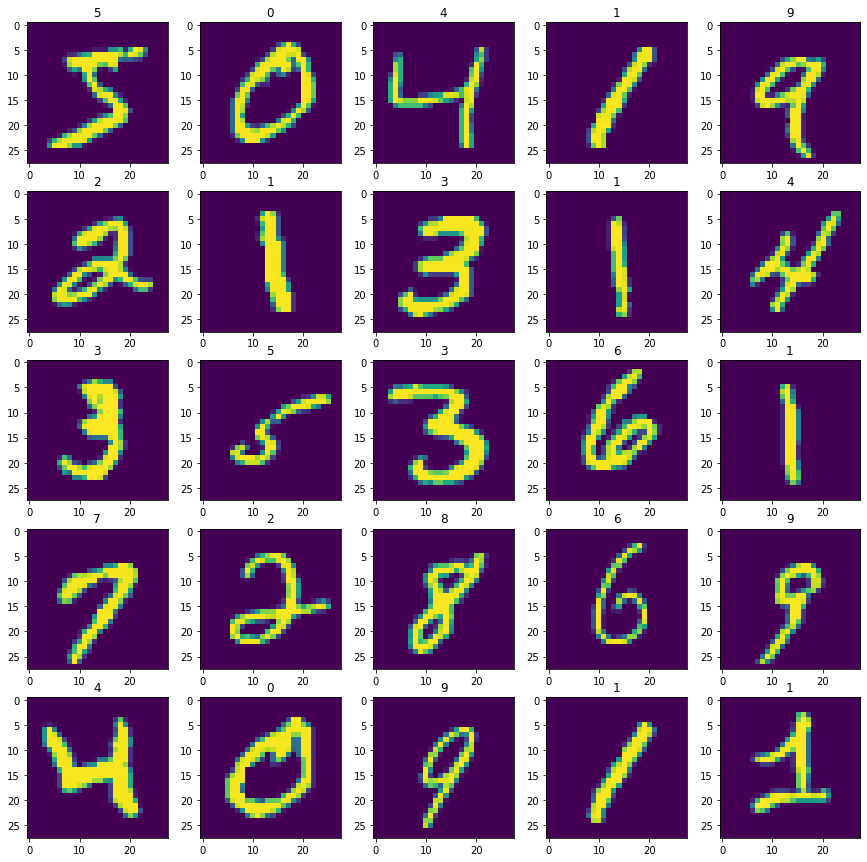

In [3]:
fig = plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.title(f'{y_train[i]}')
    plt.imshow(x_train[i])
plt.show()

### t-SNE: t-Distributed Stochastic Neighbor Embedding
t-SNE is a way to visualize higher dimensional data sets.

In [4]:
x = x_train[:2000].reshape((2000, 784))
tSNE_model = TSNE(n_components=2, random_state=0)
x2D = tSNE_model.fit_transform(x)
target_ids = range(10)
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'cyan', 'orange', 'purple'
target_names = '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'

Below, we have visualised the MNIST data set in 2D, $f:\mathbb{R}^{784}\rightarrow\mathbb{R}^2$. There are 10 classes and accordingly we see 10 clusters.

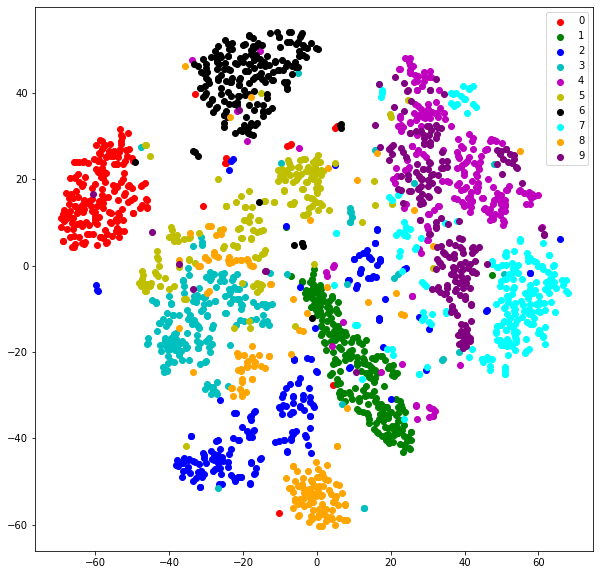

In [5]:
plt.figure(figsize=(10, 10))
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(x2D[y_train[:2000] == i, 0], x2D[y_train[:2000] == i, 1], c=c, label=label)
plt.legend()
plt.show()

### Train and test
MNIST is a simple data set. Using Adam, we can achieve an accuracy of 96% in under 3 minutes of training which is pretty quick. The network also does well at classifying images of digits I took on my phone.

In [6]:
def oplot(fig, errors, losses):
    f = fig
    plt.subplot(2, 1, 1)
    plt.plot(range(1, len(errors)), errors)
    plt.title(r'$\sum\partial C_{\theta}/\partial z_i^L$')
    plt.subplot(2, 1, 2)
    plt.plot(range(1, len(losses)), losses)
    plt.title('losses')

In [7]:
x_train, x_test = x_train.reshape((60000, 784)) / 255.0, x_test.reshape((10000, 784)) / 255.0
y_train, y_test = dl.onehot(y_train, 10), dl.onehot(y_test, 10)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:16<00:00, 45.38s/it]


accuracy: 94.89%


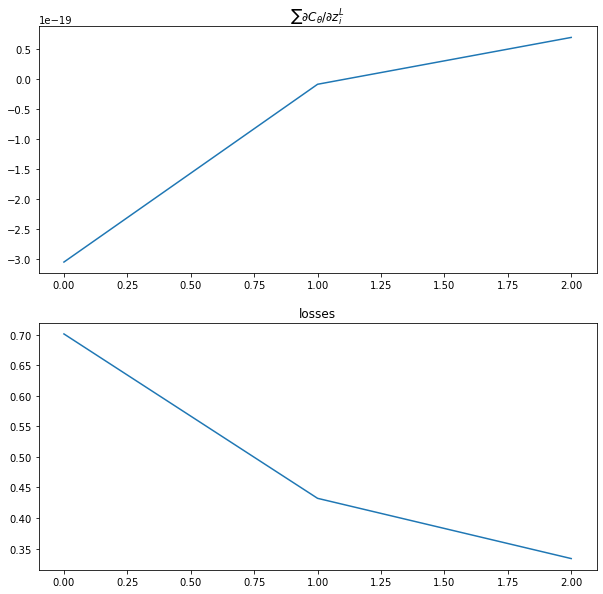

In [8]:
model = dl.Model([784, 50, 40, 10], ['none', 'relu', 'relu', 'softmax'], 'XAVIER')
model.comp('ce', dl.Adagrad(model.params()))
out, errors, losses = model.fit(x_train, y_train, epochs=3) # error -> sum(dLOSS/da^L) where a^L -> final layer input
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model, x_test, y_test)}%')

In [9]:
def process(loc, lim):
    loc = "C:/Users/rgbka/Desktop/Projects/" + loc
    img = cv2.imread(loc)
    processed_img = cv2.resize(cv2.imread(loc, 0), dsize=(28, 28)) / 255.0
    for i in range(28):
        for j in range(28):
            processed_img[i][j] = int(processed_img[i][j] < lim)
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('original')
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img)
    plt.title('processed')
    plt.show()
    return processed_img.reshape((784))

In [10]:
def test(loc, lim):
    print('prediction - ', np.argmax(model.forward(process(loc, lim))))

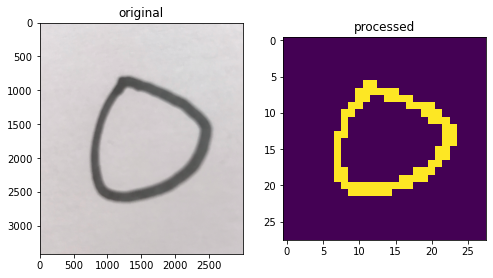

prediction -  0


In [11]:
test('zero.jpg', 0.7)

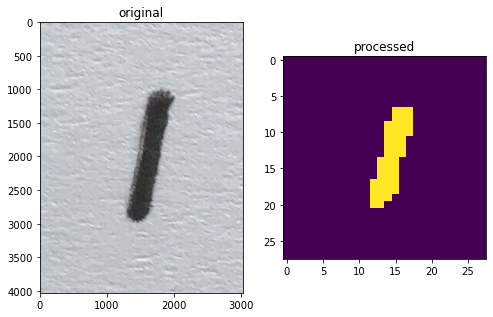

prediction -  1


In [12]:
test('one.jpg', 0.6)

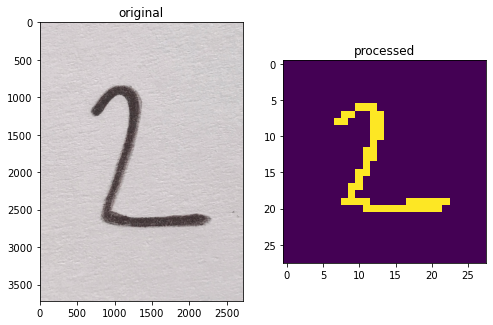

prediction -  5


In [13]:
test('two.jpg', 0.7)

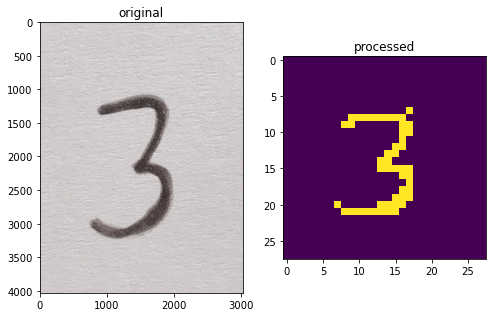

prediction -  3


In [14]:
test('three.jpg', 0.7)

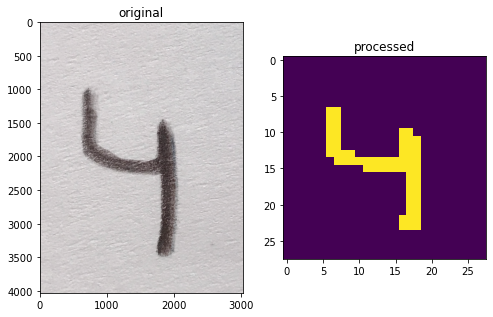

prediction -  4


In [15]:
test('four.jpg', 0.7)

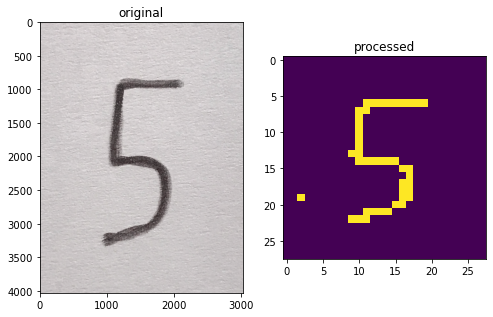

prediction -  5


In [16]:
test('five.jpg', 0.6)

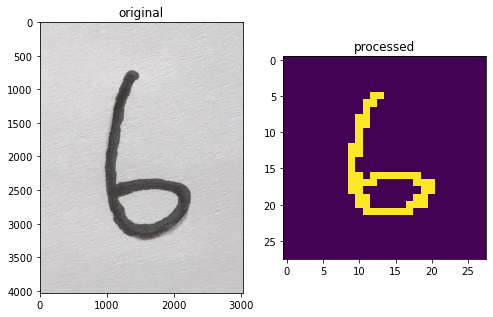

prediction -  6


In [17]:
test('six.jpg', 0.6)

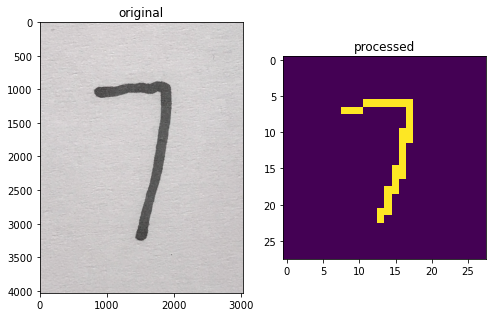

prediction -  7


In [18]:
test('seven.jpg', 0.7)

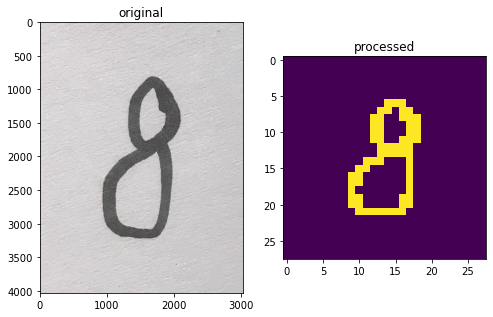

prediction -  9


In [19]:
test('eight.jpg', 0.6)

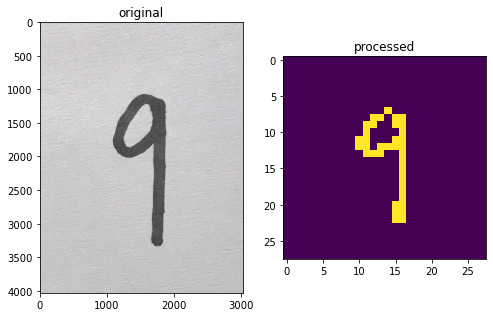

prediction -  4


In [20]:
test('nine.jpg', 0.6)

### Benchmarks
Loss function is binary cross entropy - $C_i(\theta)=-y_ilog(x_i)-(1-y_i)log(1-x_i)$ where $x_i^L$ is the output of $i^{th}$ neuron in the final layer. Xavier initialization initializes parameters based on sizes of consecutive layers. $W_{ij}^l$ is the weight connecting the $j^{th}$ neuron in layer $l$ with $i_{th}$ neuron in layer $l-1$ and it's value is sampled from a uniform distribution with bounds that depend on number of neurons in layer $l-1$ and layer $l$. Here, I've compared SGD, momentum, RMSprop and Adam. $\theta_t$ represents parameters of the network at timestep $t$.

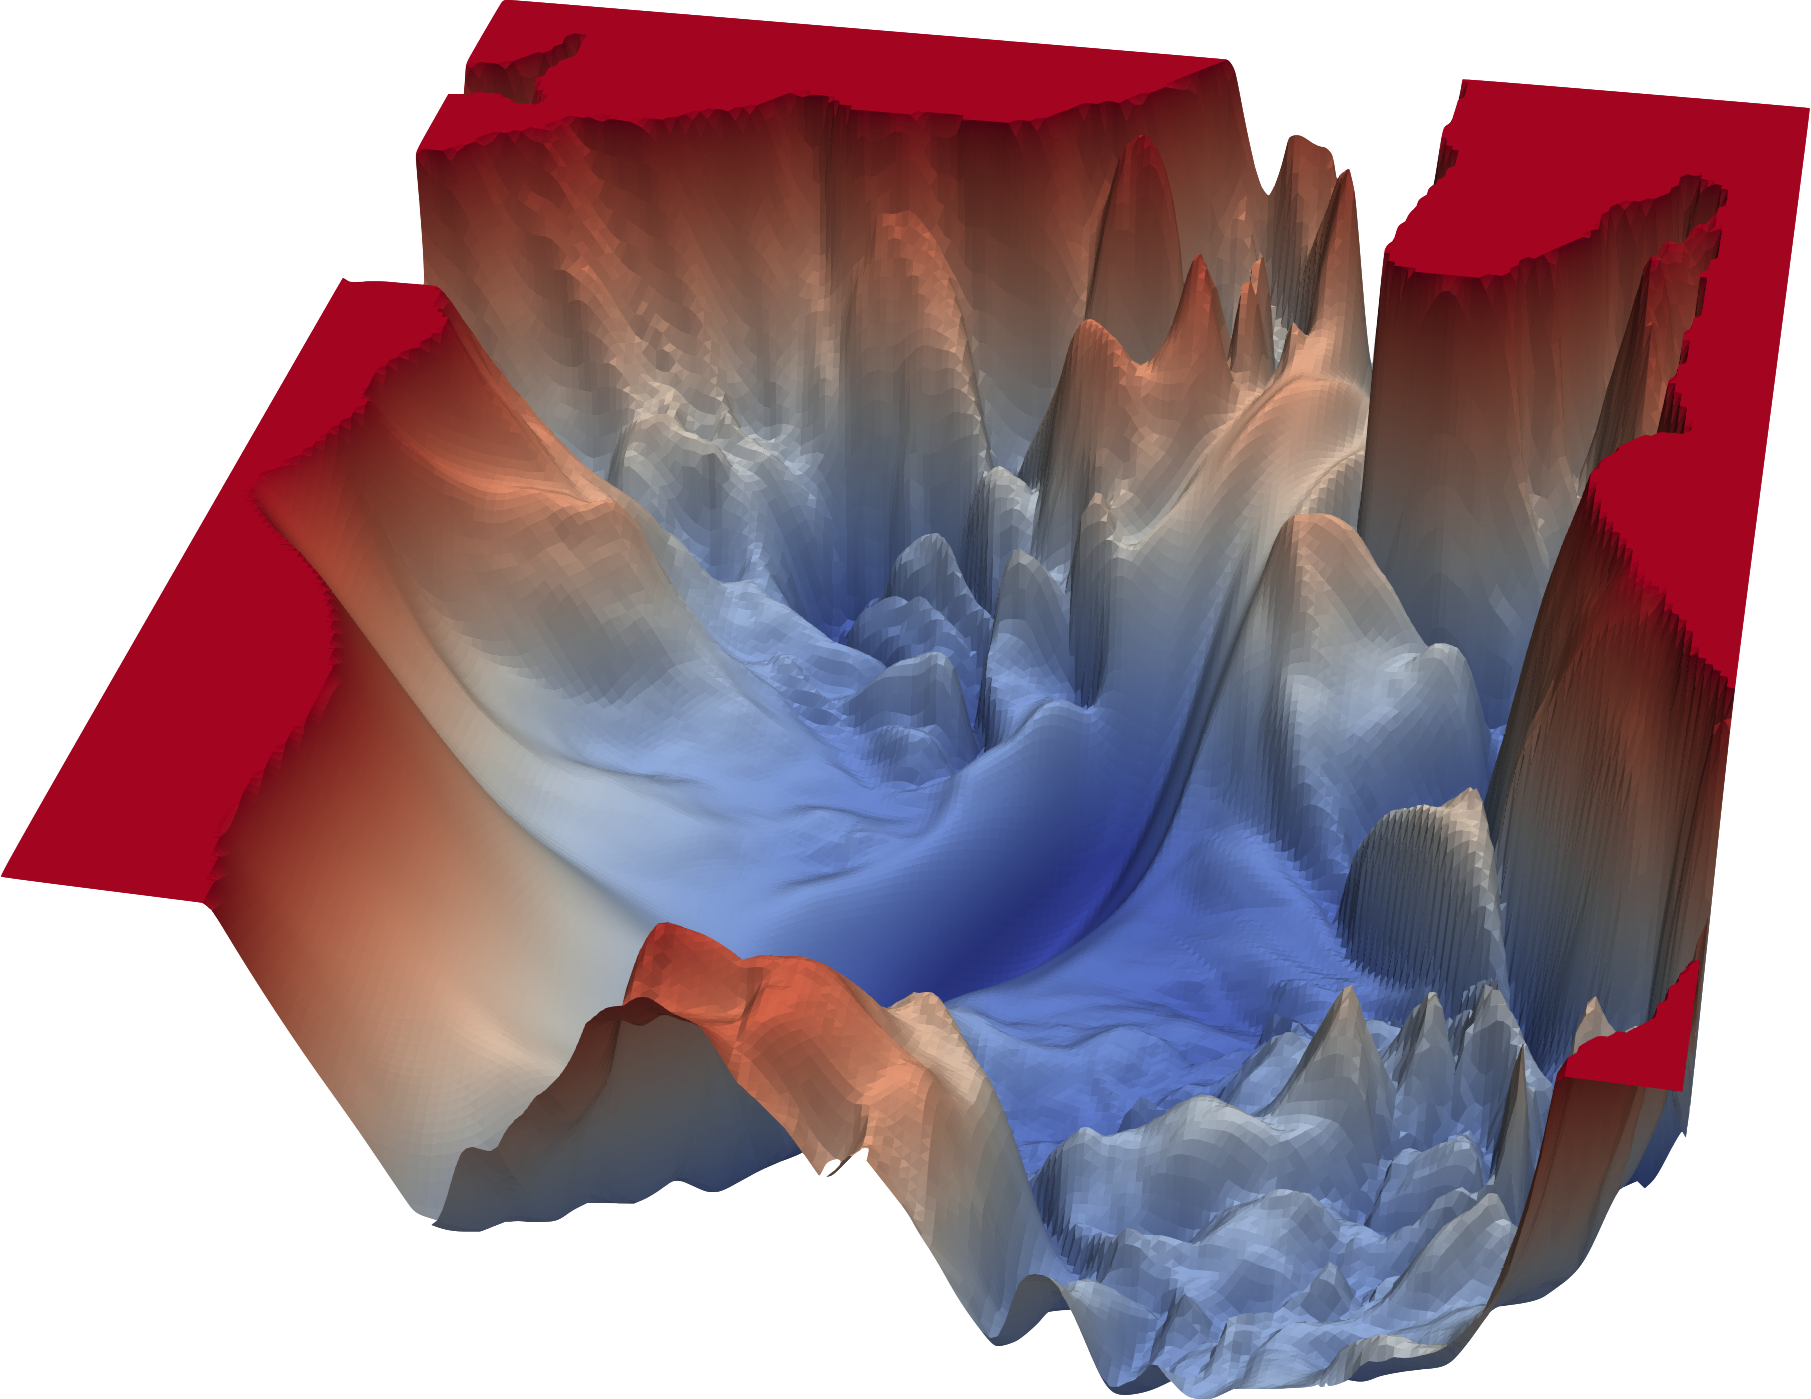

In [21]:
Image(filename="llscp.png")

The above is a visualisation of a ResNet-110 loss landscape trained on the CIFAR-10 data set (refer [Visualizing the Loss Landscape of Neural Nets](https://arxiv.org/pdf/1712.09913.pdf)). Loss landscapes can get VERY complicated, so we need smart ways to reach a good local minima (hence the need for gradient descent optimizers).

In [22]:
def xav(): return dl.Model([784, 50, 40, 10], ['none', 'relu', 'relu', 'softmax'], 'XAVIER')
def he(): return dl.Model([784, 50, 40, 10], ['none', 'relu', 'relu', 'softmax'], 'HE')

In [23]:
model1, model2, model3, model4, model5 = xav(), xav(), xav(), xav(), xav()
W, B = model1.W, model1.B
model2.W, model2.B, model3.W, model3.B, model4.W, model4.B, model5.W, model5.B = W, B, W, B, W, B, W, B
model6, model7, model8, model9, model10 = he(), he(), he(), he(), he()
W, B = model6.W, model6.B
model7.W, model7.B, model8.W, model8.B, model9.W, model9.B, model10.W, model10.B = W, B, W, B, W, B, W, B

In [24]:
model1.comp('ce', dl.SGD(model.params(), 5e-3, 0))
model2.comp('ce', dl.SGD(model.params(), 5e-3, 0.9))
model3.comp('ce', dl.RMSprop(model.params(), 5e-3, 0.1, 0.9))
model4.comp('ce', dl.Adam(model.params(), 5e-3, 0.9, 0.999))
model5.comp('ce', dl.Adagrad(model.params())) 
model6.comp('ce', dl.SGD(model.params(), 5e-3, 0))
model7.comp('ce', dl.SGD(model.params(), 5e-3, 0.9))
model8.comp('ce', dl.RMSprop(model.params(), 5e-3, 0.1, 0.9))
model9.comp('ce', dl.Adam(model.params(), 5e-3, 0.9, 0.999))
model10.comp('ce', dl.Adagrad(model.params()))

### GD with/without momentum

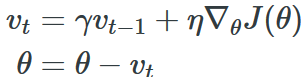

In [25]:
Image(filename="momentum.png")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:40<00:00, 44.15s/it]


accuracy: 95.06%



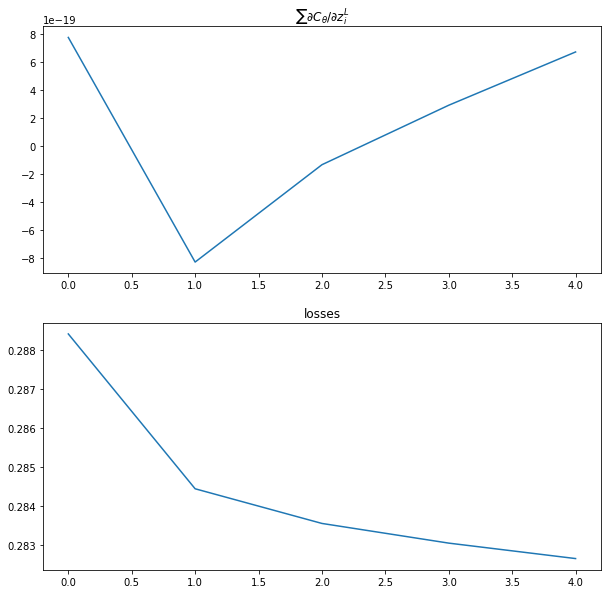

In [26]:
# no momentum and XAVIER
out, errors, losses = model1.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model1, x_test, y_test)}%\n')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:55<00:00, 47.11s/it]


accuracy: 95.14%



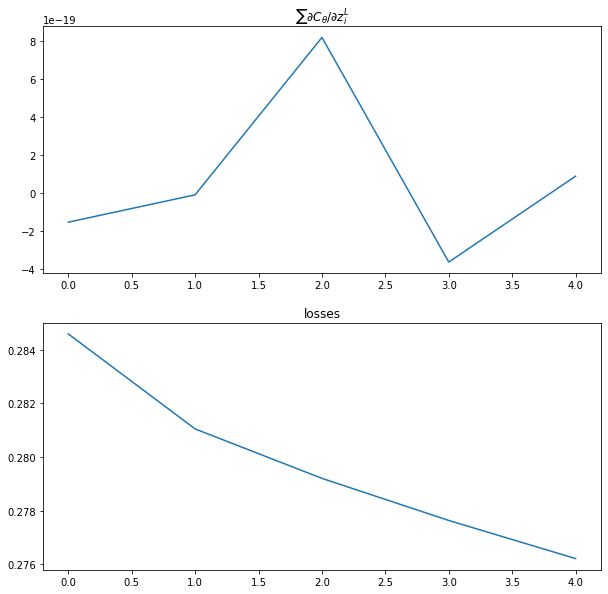

In [27]:
# momentum and XAVIER
out, errors, losses = model2.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model2, x_test, y_test)}%\n')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:04<00:00, 60.86s/it]


accuracy: 95.06%



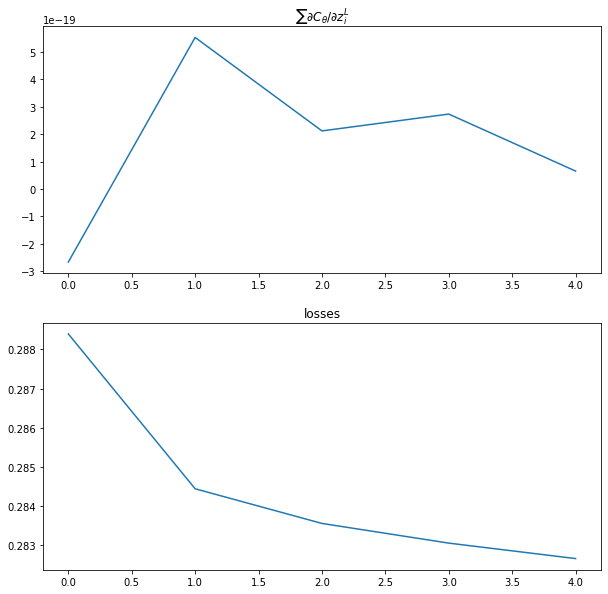

In [28]:
# no momentum and HE
out, errors, losses = model6.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model6, x_test, y_test)}%\n')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:11<00:00, 62.37s/it]


accuracy: 95.14%



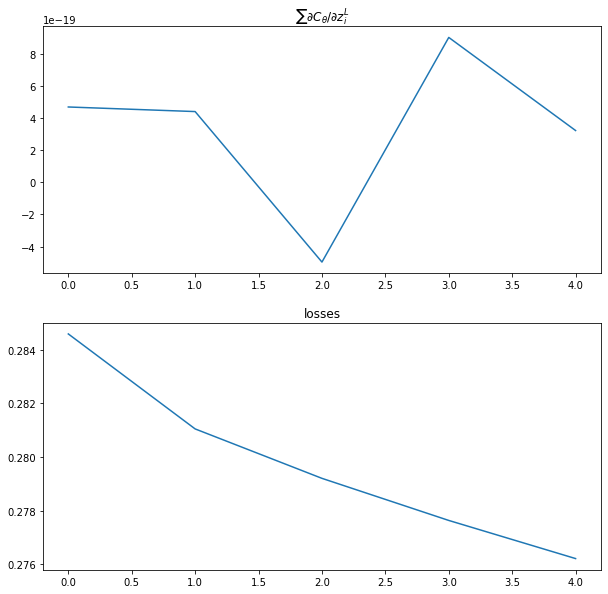

In [29]:
# momentum and HE
out, errors, losses = model7.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model7, x_test, y_test)}%\n')

### RMSprop

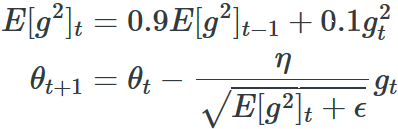

In [30]:
Image(filename="RMSprop.png")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\rgbka\Desktop\Projects\dl.py:205: RuntimeWarning: divide by zero encountered in log
  return - y * np.log(self.L[-1]) - (1 - y) * np.log(1 - self.L[-1])
C:\Users\rgbka\Desktop\Projects\dl.py:205: RuntimeWarning: invalid value encountered in multiply
  return - y * np.log(self.L[-1]) - (1 - y) * np.log(1 - self.L[-1])
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:31<00:00, 66.22s/it]


accuracy: 95.53%



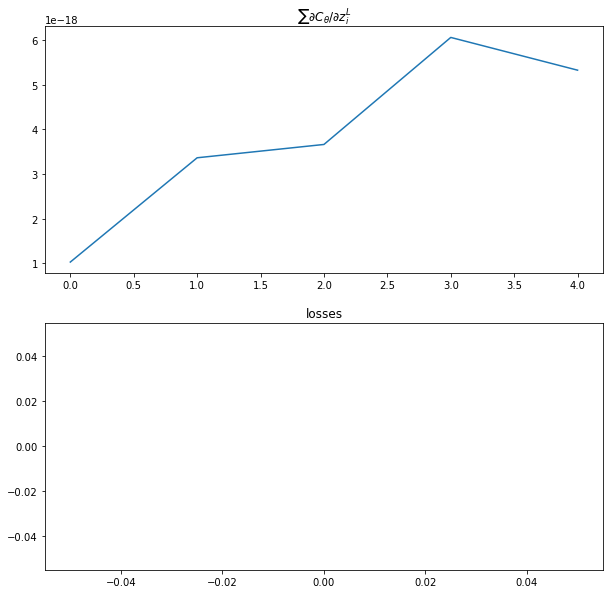

In [31]:
# XAVIER
out, errors, losses = model3.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model3, x_test, y_test)}%\n')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:51<00:00, 82.29s/it]


accuracy: 95.85%



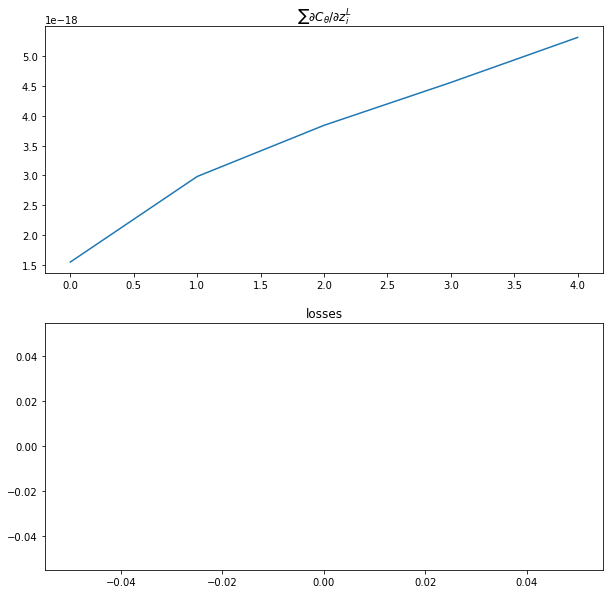

In [32]:
# HE
out, errors, losses = model8.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model8, x_test, y_test)}%\n')

### Adam

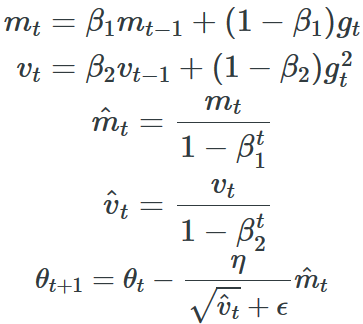

In [33]:
Image(filename="Adam.png")

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [11:07<00:00, 133.57s/it]


accuracy: 96.17%



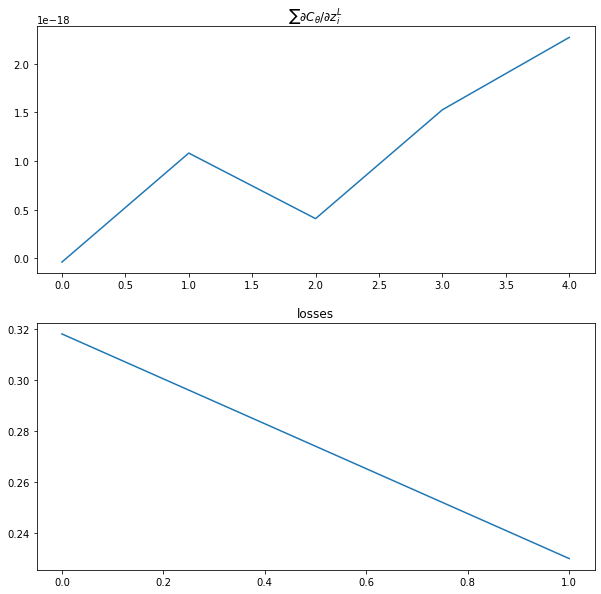

In [34]:
# XAVIER
out, errors, losses = model4.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model4, x_test, y_test)}%\n')

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:59<00:00, 119.86s/it]


accuracy: 96.14%



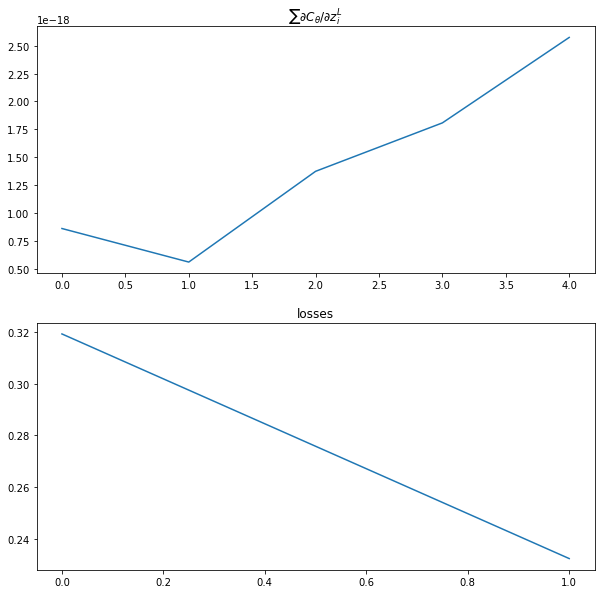

In [35]:
# HE
out, errors, losses = model9.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model9, x_test, y_test)}%\n')

### Adagrad

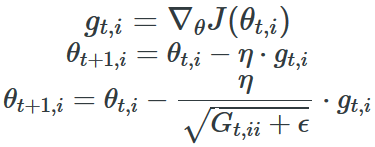

In [36]:
Image(filename="Adagrad.png")

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:55<00:00, 119.11s/it]


accuracy: 96.56%



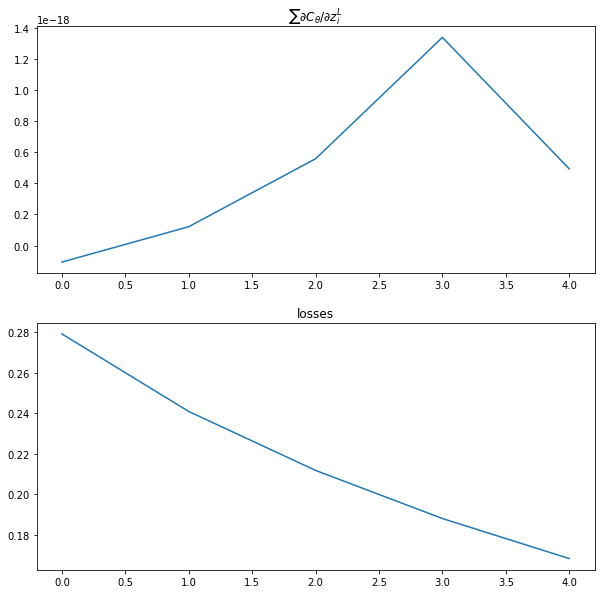

In [37]:
# XAVIER
out, errors, losses = model5.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model5, x_test, y_test)}%\n')

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:36<00:00, 115.37s/it]


accuracy: 96.58%



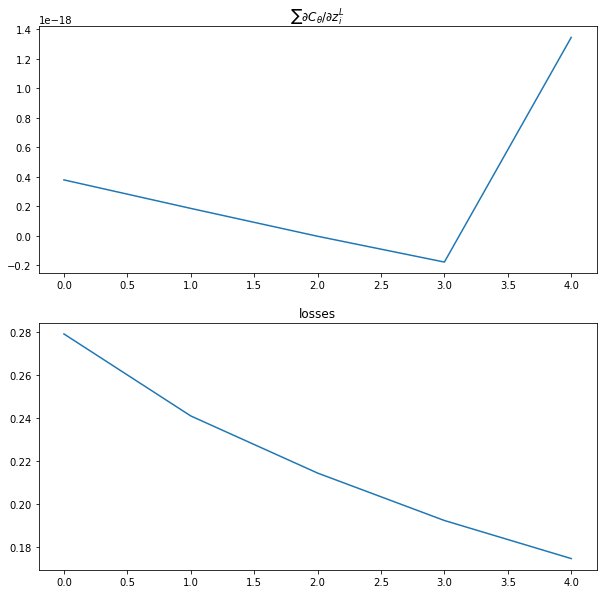

In [38]:
# HE
out, errors, losses = model10.fit(x_train, y_train, epochs=5)
oplot(plt.figure(figsize=(10, 10)), errors, losses)
print(f'accuracy: {dl.accuracy(model10, x_test, y_test)}%\n')

### Autoencoders
Autoencoders are used to learn low level representations of higher dimensional data sets. Here, there is an encoder network that learns to represent 28x28 resolution images of digits as 10 numbers (the encoding) and a decoder network that recreates the digits from the encoding. 

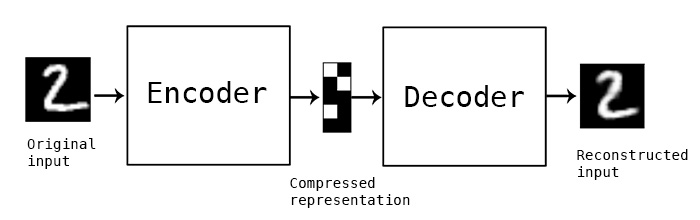

In [39]:
Image(filename="Autoencoder.jpg")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.53it/s]


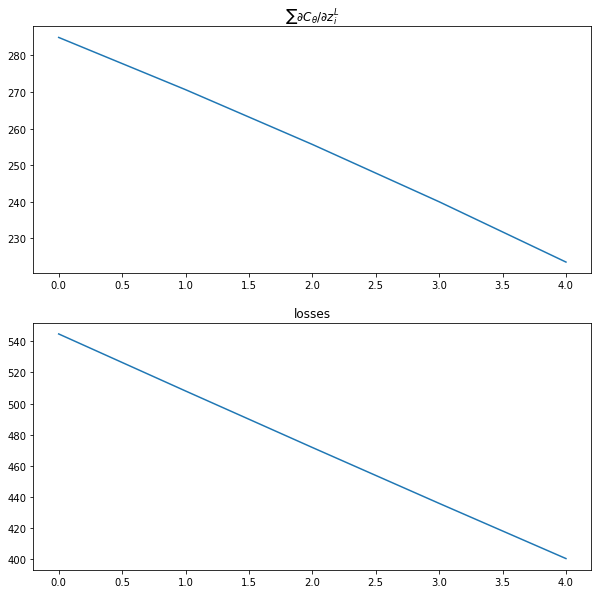

In [40]:
autoenc = dl.Model([784, 200, 100, 200, 784], ['none', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'], 'XAVIER')
autoenc.comp('ce', dl.Adam(autoenc.params(), 1e-3))
out, errors, losses = autoenc.fit(x_train[:1],  x_train[:1], epochs=5, batch_size=1)
oplot(plt.figure(figsize=(10, 10)), errors, losses)

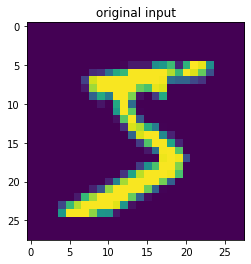

In [41]:
plt.title('original input')
im = plt.imshow(np.reshape(x_train[0], (28, 28)))

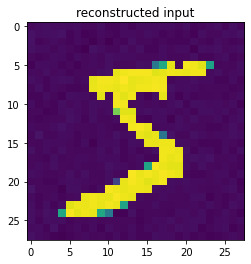

In [42]:
plt.title('reconstructed input')
im = plt.imshow(np.reshape(autoenc.forward(x_train[0]), (28, 28)))